## Binary Classification of Employee Attrition Dataset on Kaggle


## Problems with creating a good classifier
1. Dataset is highly imbalanced, lots of No and less Yes in 'Attrition' target variable
2. Precision Recall metric : lower emphasis on TrueNegative, higher emphasis on 'positive' 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

import logging
from datetime import datetime
import os

# Create a directory for logs if it doesn't exist
if not os.path.exists('logs'):
    os.makedirs('logs')

# Set up logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f"logs/run_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)

# Function to log results
def log_results(message):
    logging.info(message)


In [2]:
df = pd.read_csv('employee_attrition.csv')
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


### Dropping Useless Features
- Have the same value throughout the dataset

In [3]:
df.drop(columns=['EmployeeCount','Over18','StandardHours','EmployeeNumber'],inplace=True)

### Encoding categorical data
- ordinal data encoded into 0,1,2,3
- nominal data encoded using pandas dummies

In [4]:
df['Attrition'] = df['Attrition'].map({'Yes':1,'No':0})
df['BusinessTravel'] = df['BusinessTravel'].map({'Non-Travel' : 0,'Travel_Rarely' : 1, 'Travel_Frequently' : 2})
df['OverTime']=df['OverTime'].map({'Yes' : 1, 'No' : 0})
df['Gender'] = df['Gender'].map({'Male' : 0, 'Female' : 1})

df = pd.get_dummies(df,drop_first=True)


### Baseline Model
- Logistic Regression
- LightGBM

In [5]:
log_results("removing years and month run")
X = df.drop(columns=['Attrition','YearsInCurrentRole','MonthlyIncome'])
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2024-07-25 17:04:51,018 - INFO - removing years and month run


In [6]:
# Evaluate Model
def evaluate(model,X_train,y_train,X_test,y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    log_results(f"Accuracy:{accuracy}")
    log_results(f"\nConfusion Matrix:{conf_matrix}\n")
    log_results(f"\nClassification Report:{class_report}\n")
    print('---------------')
    log_results(f"ROC AUC Score:{roc_auc}")
    


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

evaluate(log_reg,X_train,y_train,X_test,y_test)

2024-07-25 17:04:51,171 - INFO - Accuracy:0.8605442176870748
2024-07-25 17:04:51,172 - INFO - 
Confusion Matrix:[[253   2]
 [ 39   0]]

2024-07-25 17:04:51,174 - INFO - 
Classification Report:              precision    recall  f1-score   support

           0       0.87      0.99      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.86       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.86      0.80       294


2024-07-25 17:04:51,175 - INFO - ROC AUC Score:0.7063851181498241


---------------


In [8]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

lgbm.fit(X_train,y_train)

evaluate(lgbm,X_train,y_train,X_test,y_test)


2024-07-25 17:04:51,528 - INFO - Accuracy:0.8945578231292517
2024-07-25 17:04:51,530 - INFO - 
Confusion Matrix:[[251   4]
 [ 27  12]]

2024-07-25 17:04:51,532 - INFO - 
Classification Report:              precision    recall  f1-score   support

           0       0.90      0.98      0.94       255
           1       0.75      0.31      0.44        39

    accuracy                           0.89       294
   macro avg       0.83      0.65      0.69       294
weighted avg       0.88      0.89      0.87       294


2024-07-25 17:04:51,535 - INFO - ROC AUC Score:0.7759678230266466


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 198, number of negative: 978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168367 -> initscore=-1.597243
[LightGBM] [Info] Start training from score -1.597243
---------------


In [9]:
from sklearn.metrics import precision_recall_curve,auc

def plot_pr_curve(model):
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    log_results(f"Precision-Recall AUC: {pr_auc:.2f}")

    import matplotlib.pyplot as plt

    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

2024-07-25 17:04:51,601 - INFO - Precision-Recall AUC: 0.26


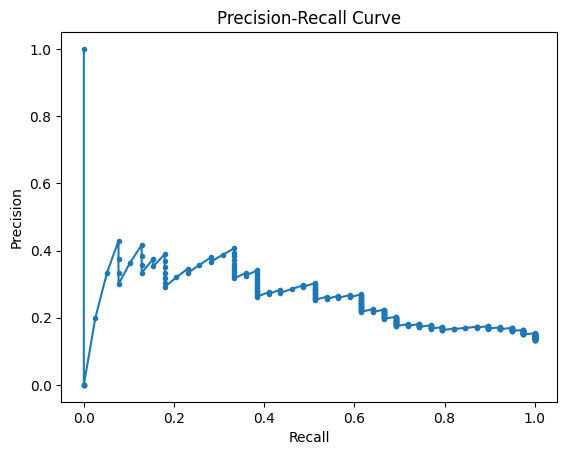

2024-07-25 17:04:51,802 - INFO - Precision-Recall AUC: 0.50


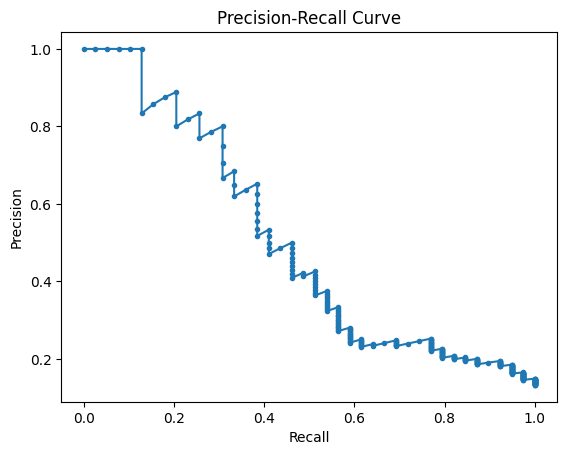

In [10]:
plot_pr_curve(log_reg)
plot_pr_curve(lgbm)

### Dealing With Class Imbalance
As you can see the PR-Curve of above models are not performing well. PR-AUC value of < 0.5 basically means that we are better off random guessing than running our model for prediction purpose

- SMOTE

In [11]:
# Trying out SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)



In [12]:
X_resampled_train,X_resampled_test,y_resampled_train,y_resampled_test = train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=42)



log_reg.fit(X_resampled_train,y_resampled_train)
evaluate(log_reg,X_resampled_train,y_resampled_train,X_resampled_test,y_resampled_test)

2024-07-25 17:04:52,332 - INFO - Accuracy:0.7348178137651822
2024-07-25 17:04:52,334 - INFO - 
Confusion Matrix:[[181  69]
 [ 62 182]]

2024-07-25 17:04:52,335 - INFO - 
Classification Report:              precision    recall  f1-score   support

           0       0.74      0.72      0.73       250
           1       0.73      0.75      0.74       244

    accuracy                           0.73       494
   macro avg       0.73      0.73      0.73       494
weighted avg       0.74      0.73      0.73       494


2024-07-25 17:04:52,337 - INFO - ROC AUC Score:0.8102786885245902


---------------


In [13]:
lgbm.fit(X_resampled_train,y_resampled_train)
evaluate(lgbm,X_resampled_train,y_resampled_train,X_resampled_test,y_resampled_test)

2024-07-25 17:04:52,505 - INFO - Accuracy:0.9230769230769231
2024-07-25 17:04:52,506 - INFO - 
Confusion Matrix:[[240  10]
 [ 28 216]]

2024-07-25 17:04:52,508 - INFO - 
Classification Report:              precision    recall  f1-score   support

           0       0.90      0.96      0.93       250
           1       0.96      0.89      0.92       244

    accuracy                           0.92       494
   macro avg       0.93      0.92      0.92       494
weighted avg       0.93      0.92      0.92       494


2024-07-25 17:04:52,509 - INFO - ROC AUC Score:0.9723606557377049


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 989, number of negative: 983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501521 -> initscore=0.006085
[LightGBM] [Info] Start training from score 0.006085
---------------


2024-07-25 17:04:52,545 - INFO - Precision-Recall AUC: 0.91


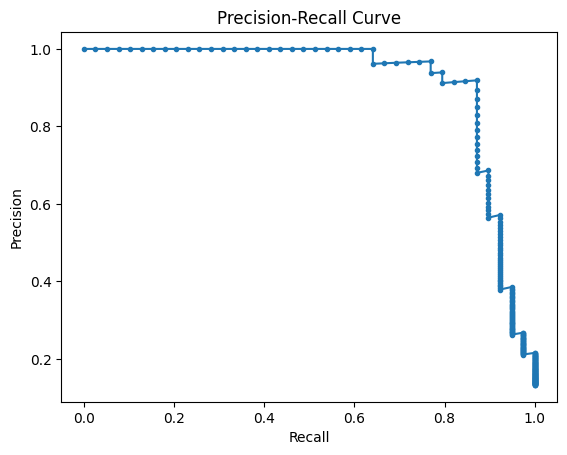

In [14]:
plot_pr_curve(lgbm)

### Feature Importance Analysis 
- Embedded method for feature selection, take advantage of lightgbm feature_importance buitlin metric to visualize features that contributed most to the model performance

In [15]:
def plot_feature_importance(model,feature_names):
    # Extract feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Change index for plotting purpose
    feature_importance_df.set_index('feature',inplace=True)
    feature_importance_df.plot(kind='bar',figsize=(9,6),use_index='feature')
    


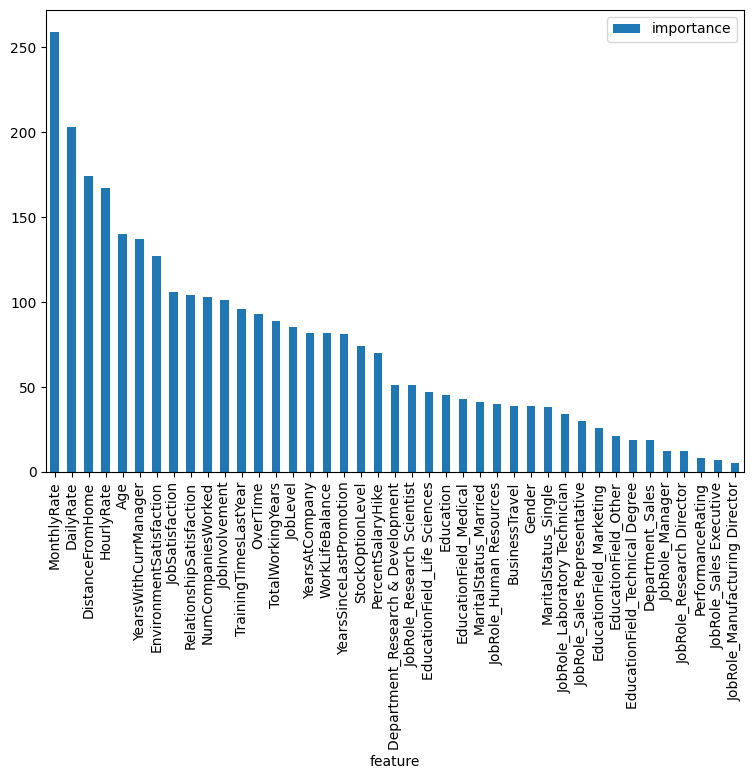

In [16]:
plot_feature_importance(lgbm,X_train.columns)


### Correlation Analysis
- EDA told us that 'MonthlyIncome' has high correlation with 'JobLevel' , but after using all features to train model, 'MonthlyIncome' end up being the highest contributing feature, that sounds fishy.
- Hence, we filter out features with high collinearity and observe the change in model performance and contributing feature.
- High correlation pairs are identified in survival.ipynb and attrition.ipynb and stored using %store magic command to share data between notebooks
  - (MonthlyIncome, JobLevel) have a 0.9 score in Spearson Correlation
- MonthlyIncome and JobLevel have a very highscore in VIF. Once we removed one of it from the feature set the VIF is lowered to a tolerable value
  - Decide which to exclude based on survival analysis 

In [17]:
# excluding onehot encoded features
numerical_df = df.select_dtypes(exclude='bool')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(numerical_df)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                    Variable         VIF
0                      const  212.289412
1                        Age    2.060202
2                  Attrition    1.277113
3             BusinessTravel    1.029554
4                  DailyRate    1.020355
5           DistanceFromHome    1.024396
6                  Education    1.059873
7    EnvironmentSatisfaction    1.033666
8                     Gender    1.018090
9                 HourlyRate    1.018525
10            JobInvolvement    1.037493
11                  JobLevel   11.217502
12           JobSatisfaction    1.032095
13             MonthlyIncome   10.809040
14               MonthlyRate    1.014373
15        NumCompaniesWorked    1.279925
16                  OverTime    1.107908
17         PercentSalaryHike    2.522928
18         PerformanceRating    2.518505
19  RelationshipSatisfaction    1.024419
20          StockOptionLevel    1.039154
21         TotalWorkingYears    4.787075
22     TrainingTimesLastYear    1.020593
23           Wor

In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(lgbm, X_resampled_train, y_resampled_train, cv=5, scoring='average_precision')



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 791, number of negative: 786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1577, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501585 -> initscore=0.006341
[LightGBM] [Info] Start training from score 0.006341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 791, number of negative: 786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of 

In [19]:
# Print the accuracy for each fold and the mean accuracy
log_results(f"Cross-validation scores: {scores}")
log_results(f"Mean cross-validation score: {scores.mean()}")

2024-07-25 17:04:54,376 - INFO - Cross-validation scores: [0.98139408 0.9776428  0.97939756 0.97293791 0.9794191 ]
2024-07-25 17:04:54,377 - INFO - Mean cross-validation score: 0.9781582887022632


### Final Model
- LGBMClassifier + SMOTE + remove 'MonthlyIncome' : highest score in ROC-AUC , PR-AUC 